In [263]:
import os
from pathlib import Path

from pycocotools.coco import COCO
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pil_to_tensor

from src import ROOT_DIR
from src.datasets import MixedDataset, BildacherBackgroundDataset
from src.utils import plot_tensor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mixed dataset

In [197]:
dataset = MixedDataset()

In [198]:
image, label, patch = dataset[0]
image.shape, label, patch

(torch.Size([3, 1408, 2048]),
 array([0.       , 0.209082 , 0.540901 , 0.1658007, 0.0668864]),
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=340x94>)

### Check patches

In [217]:
label, label.shape 

(array([0.       , 0.209082 , 0.540901 , 0.1658007, 0.0668864]), (5,))

In [221]:
x, y, w, h = label[1:].ravel()
x, y, w, h

(0.209082, 0.540901, 0.1658007, 0.0668864)

(1408, 2048)

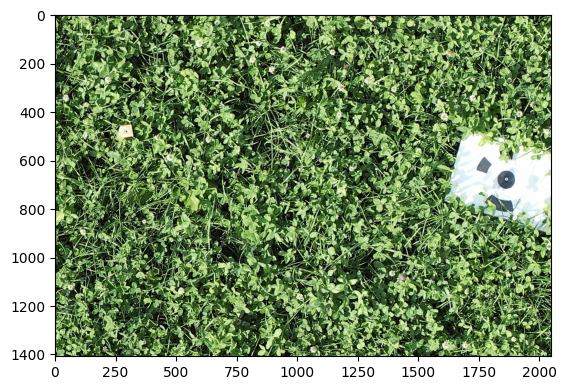

In [207]:
plot_tensor(image)
H = image.shape[1]
W = image.shape[2]
image

In [231]:
patch_height = round(h * H)
patch_width = round(w * W)
patch_height, patch_width

(94, 340)

In [242]:
x_center = round(x * W)
y_center = round(y * H)
_patch = image[:, y_center - patch_height//2 : y_center + patch_height//2, x_center - patch_width//2 : x_center + patch_width//2]

torch.Size([3, 94, 340])


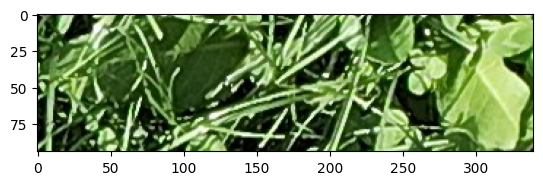

In [274]:
print(_patch.shape)
plot_tensor(_patch)

torch.Size([3, 94, 340])


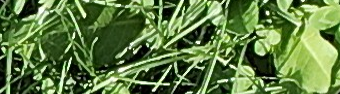

In [220]:
print(pil_to_tensor(patch).shape)
patch

Patch extracted from labels match! (before doing CenterCrop)

### Discard labels, patches and images where label is outside CenterCrop

## Bildacher backgrounds dataset

torch.Size([3, 1280, 1280])


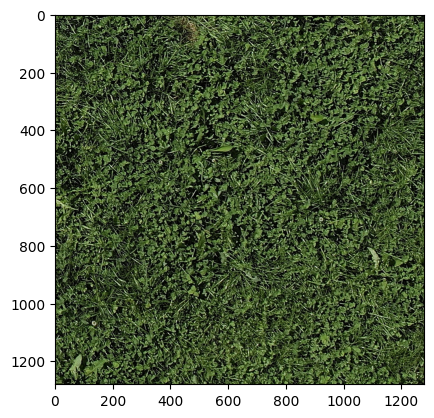

In [273]:
bildacher = BildacherBackgroundDataset()
image = bildacher[0]
print(image.shape)
plot_tensor(image)